In [ ]:
#Importing necessary libraries

import tensorflow as tf
import os, keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa
import numpy as np
from tensorflow.keras.regularizers import l2

In [ ]:
# Define the path to the data directory

data_dir = '/content/drive/MyDrive/DS/Final_Dataset_A_Z_SK_NewSign'
test_dir = '/content/drive/MyDrive/DS/Test_NEW_SK_A_Z_1_9'
IMAGE_SIZE=32
BATCH_SIZE=32

# Calculate the split sizes
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Get the total number of images
total_images = sum([len(files) for r, d, files in os.walk(data_dir)])

# Calculate the number of images for each split
train_size = int(total_images * train_split)
val_size = int(total_images * val_split)
test_size = int(total_images * test_split)

# Calculate the steps per epoch for training and validation
train_steps_per_epoch = train_size // BATCH_SIZE
val_steps_per_epoch = val_size // BATCH_SIZE
test_steps_per_epoch = test_size // BATCH_SIZE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data generator for training set for Custom Model
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.3
)

# Data generator for validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=val_split
)

# Data generator for testing set (no data augmentation)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               rotation_range=10,
                                                               width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                               horizontal_flip=True,
                                                                shear_range=0.1,
                                                                  zoom_range=0.1,
                                                               brightness_range=[0.7, 1.3],
    channel_shift_range=5,  # Color Jittering
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape),
)


In [ ]:
# Load the data for training set
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

#Load the data for validation set
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load the data for testing set
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE,
class_mode='categorical',
shuffle=False,
)

Found 53528 images belonging to 35 classes.
Found 22924 images belonging to 35 classes.
Found 17584 images belonging to 35 classes.


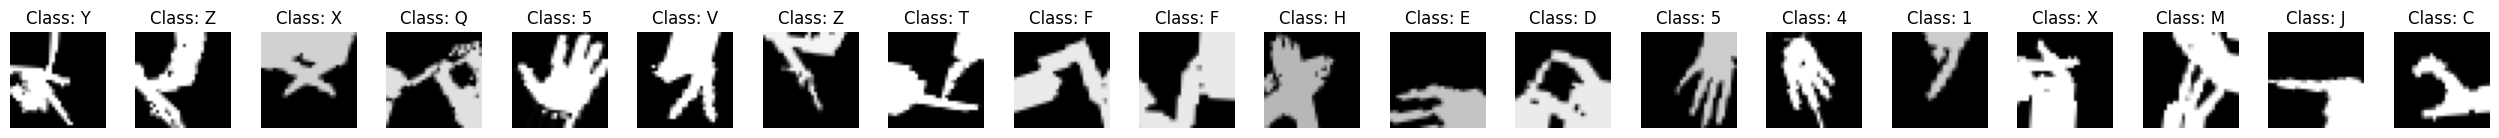

In [ ]:
# Extracting class labels from the training generator
labels = [k for k in train_generator.class_indices]

# Generating a batch of samples from the training generator
sample_generate = train_generator.next()

# Extracting images and titles (labels) from the generated batch
images = sample_generate[0]
titles = sample_generate[1]

# Creating a Matplotlib figure
plt.figure(figsize=(32, 32))

# Looping through the images and titles to create subplots
for i in range(20):
    # Creating a subplot
    plt.subplot(20, 20, i + 1)

    # Adjusting subplot spacing
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Displaying the image
    plt.imshow(images[i])

    # Displaying the class label as the title
    plt.title(f'Class: {labels[np.argmax(titles[i], axis=0)]}')

    # Turning off axis for better visualization
    plt.axis("off")

# Showing the plot
plt.show()

In [ ]:
# Creating a Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())  # Batch normalization to normalize the activations
model.add(MaxPooling2D(2, strides=2))  # MaxPooling to downsample the spatial dimensions

# Second Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', groups=1))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, strides=2))

# Third Convolutional Layer
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', groups=1))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, strides=2))

In [ ]:
# Flatten the output from the convolutional layers
model.add(Flatten())

# Dense layer with 512 units and ReLU activation, using L2 regularization
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Batch normalization to normalize the activations
model.add(Dropout(0.5))  # Dropout for regularization

# Dense layer with 256 units and ReLU activation, using L2 regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with 35 units (assuming it's a 35-class classification problem) and softmax activation
model.add(Dense(35, activation='softmax'))

In [ ]:
# Define the optimizer with a learning rate of 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Compile the model with the specified optimizer, loss, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
# Specify the path to save the entire model
model_save_path = '/content/drive/MyDrive/DS/Demodata/OwnModel_15Oct_A_Z_1_9.h5'

# Create a ModelCheckpoint callback to save the model during training
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False
)

# Create an EarlyStopping callback to stop training early if the validation loss doesn't improve
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)


In [ ]:
# Function to print a message every 5 minutes
import time
def print_keep_alive():
    while True:
        print("Colab session is active.")
        time.sleep(400)  # Wait for 5 minutes

# Start the keep-alive loop in the background
import threading
keep_alive_thread = threading.Thread(target=print_keep_alive)
keep_alive_thread.daemon = True
keep_alive_thread.start()

Colab session is active.


In [ ]:
# Training the custom model using the fit method
history=model.fit(train_generator,
                  steps_per_epoch=len(train_generator),
                  epochs=150,
                  validation_data=validation_generator,
                  validation_steps=len(validation_generator),
                  callbacks=[cp_callback, es_callback]
                 )


Epoch 1/150
1673/1673 [==============================] - ETA: 0s - loss: 1.2005 - accuracy: 0.7837Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.
Colab session is active.

Epoch 1: saving model to /content/drive/MyDrive/DS/Demodata/OwnModel_15Oct_A_Z_1_9.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1673/1673 [==============================] - 6694s 4s/step - loss: 1.2005 - accuracy: 0.7837 - val_loss: 1.2870 - val_accuracy: 0.8008
Epoch 2/150
1673/1673 [==============================] - ETA: 0s - loss: 0.9626 - accuracy: 0.8356
Epoch 2: saving model to /content/drive/MyDrive/DS/Demodata/OwnModel_15Oct_A_Z_1_9.h5
1673/1673 [==============================] - 471s 281ms/step - loss: 0.9626 - accuracy: 0.8356 - val_loss: 1.0408 - val_accuracy: 0.8698
Epoch 3/150
1673/1673 [==============================] - ETA: 0s - loss: 0.8792 - accuracy: 0.8555
Epoch 3: saving model to /content/drive/MyDrive/DS/Demodata/OwnModel_15Oct_A_Z_1_9.h5
1673/1673 [==============================] - 468s 280ms/step - loss: 0.8792 - accuracy: 0.8555 - val_loss: 0.9249 - val_accuracy: 0.8792
Epoch 4/150
1673/1673 [==============================] - ETA: 0s - loss: 0.8321 - accuracy: 0.8701
Epoch 4: saving model to /content/drive/MyDrive/DS/Demodata/OwnModel_15Oct_A_Z_1_9.h5
1673/1673 [=========================

# An example image with the augmentations applied

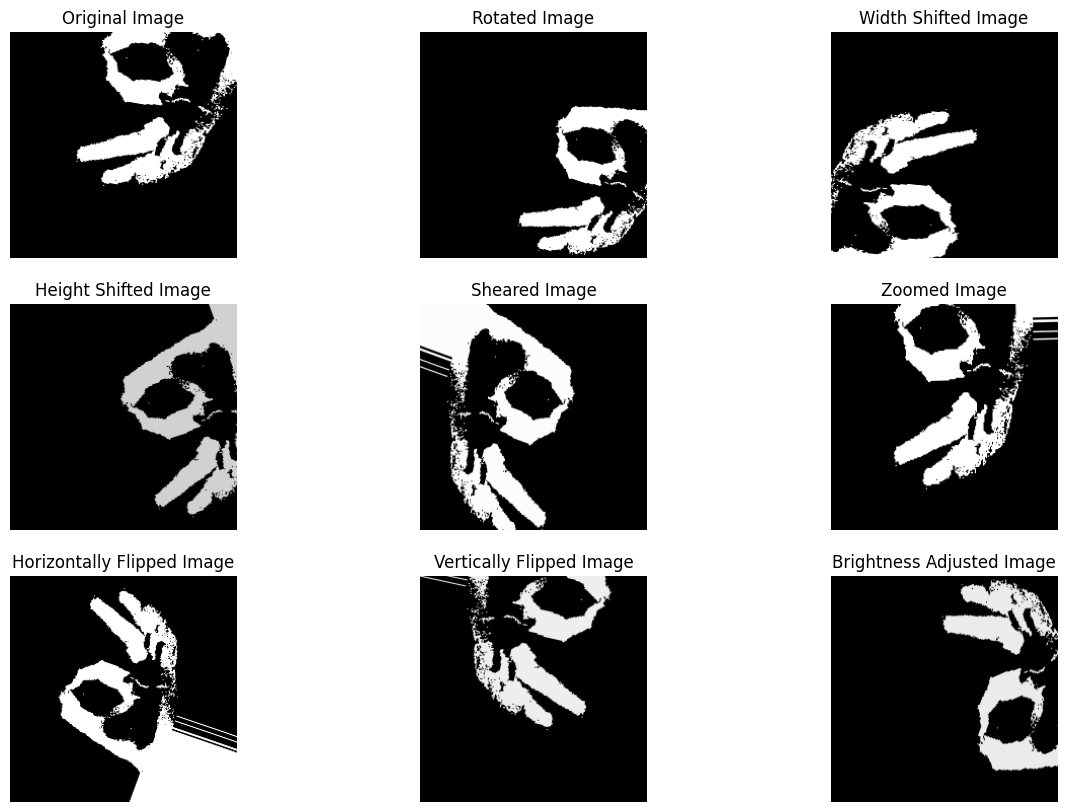

In [1]:
#Import necessary libraries
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Image path
img_path = '/Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/Sign_Lang_Custom_Dataset _Final copy/0/K1.png'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

# Data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3]
)

# Generate augmented images
augmented_images = []

# Apply each augmentation and store the augmented images
for i in range(9):  # Generate 9 augmented images
    augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
    augmented_images.append(augmented_img)

# Titles for each augmented image
titles = [
    "Original Image",
    "Rotated Image",
    "Width Shifted Image",
    "Height Shifted Image",
    "Sheared Image",
    "Zoomed Image",
    "Horizontally Flipped Image",
    "Vertically Flipped Image",
    "Brightness Adjusted Image"
]

# Display the images
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.show()

# Custom Model Feature Visualization

1/1 [==============================] - 0s 104ms/step


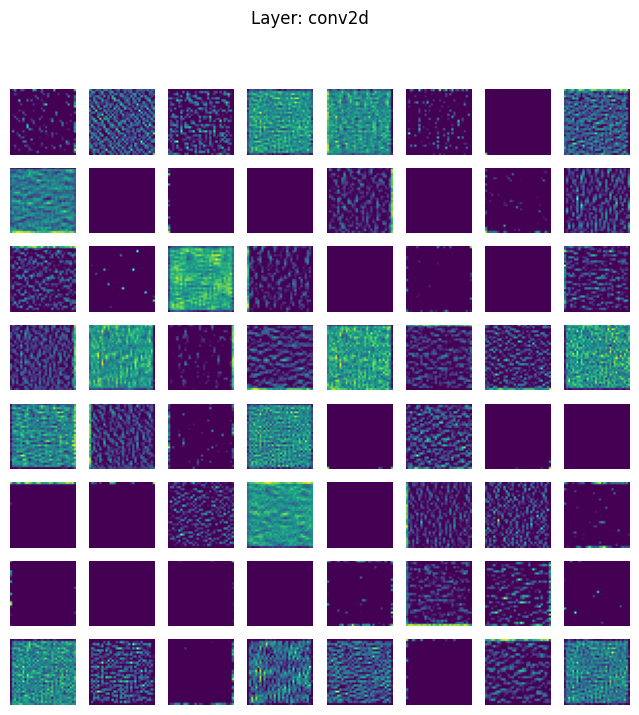

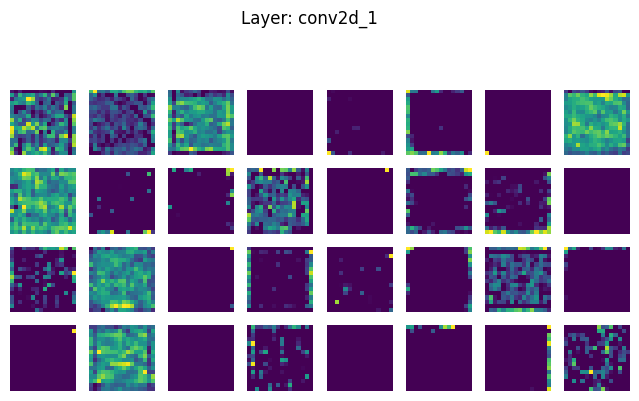

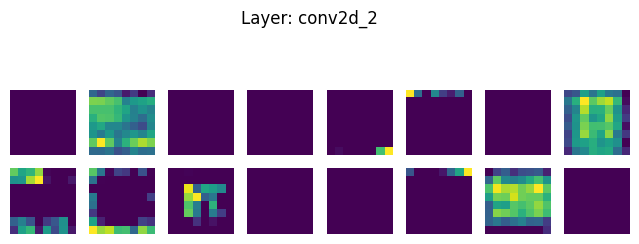

In [4]:
#Import necessary libraries
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.models import load_model


# Assuming your model is named 'model_1'
model_1 = load_model('/content/drive/MyDrive/DS/Demodata/OwnModel_15Oct_A_Z_1_9.h5')
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']  # Names of the convolutional layers you want to visualize
num_layers = len(layer_names)

# Create a new model that outputs the intermediate layer activations
activation_models = [Model(inputs=model_1.inputs, outputs=model_1.get_layer(layer_name).output) for layer_name in layer_names]

# Load an example image (replace this with your own image data)
example_image = np.random.random((1, 32, 32, 3))

# Get the intermediate layer activations for the example image
activations = [activation_model.predict(example_image) for activation_model in activation_models]

# Plot the feature maps
for i in range(num_layers):
    plt.figure(figsize=(8, 8))
    for j in range(activations[i].shape[-1]):
        plt.subplot(8, 8, j + 1)
        plt.imshow(activations[i][0, :, :, j], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Layer: {layer_names[i]}')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


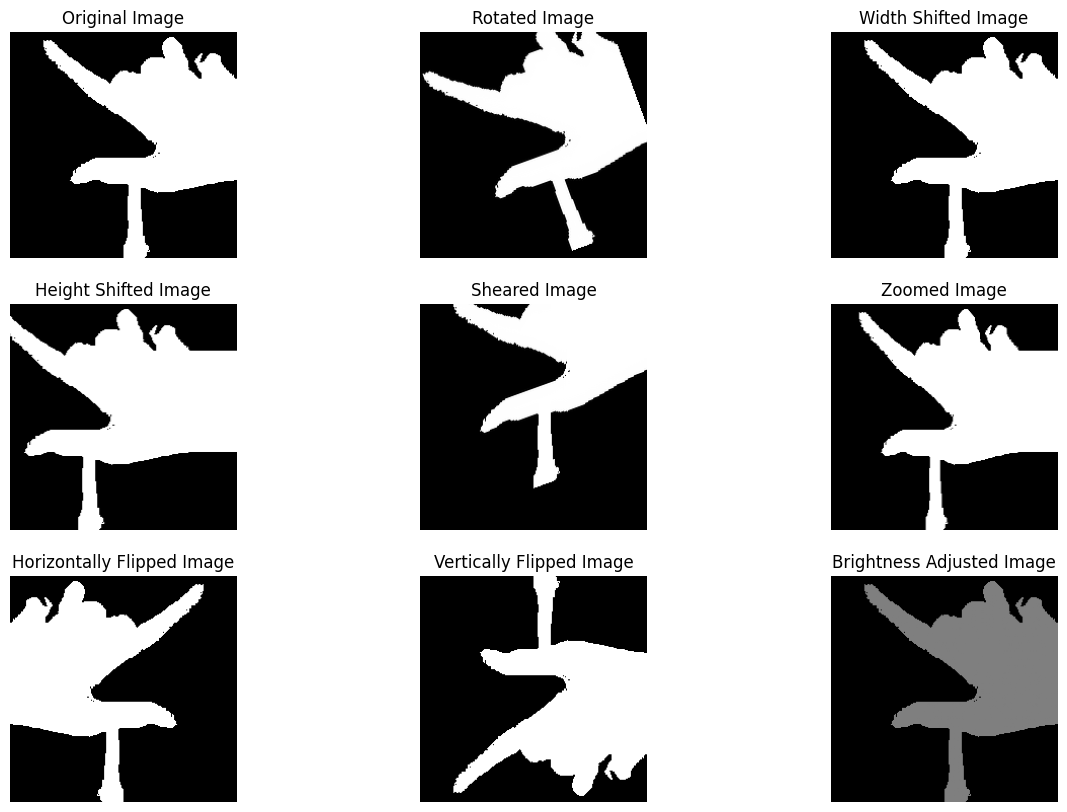

In [19]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img, array_to_img
import numpy as np
from PIL import ImageEnhance

# Image path
img_path = '/Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/Sign_Lang_Custom_Dataset _Final copy/Y/061.png'

# Load and preprocess the image
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)

# Data augmentation functions
def rotate_image(img_array, angle):
    return rotate(img_array, angle, reshape=False)

def shift_image(img_array, width_shift, height_shift):
    return image.apply_affine_transform(img_array, tx=width_shift, ty=height_shift)

def shear_image(img_array, shear):
    afine_tf = np.array([[1, np.tan(np.radians(shear)), 0],
                         [0, 1, 0],
                         [0, 0, 1]])
    return affine_transform(img_array, afine_tf)

def zoom_image(img_array, zoom):
    return image.apply_affine_transform(img_array, zx=zoom, zy=zoom)

def flip_image(img_array, horizontal=False, vertical=False):
    if horizontal:
        img_array = np.fliplr(img_array)
    if vertical:
        img_array = np.flipud(img_array)
    return img_array

def adjust_brightness(img_array, factor):
    img = array_to_img(img_array * 255.0)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(factor)
    return img_to_array(img) / 255.0

# Generate augmented images
augmented_images = [
    img_array / 255.0,  # Original Image
    rotate_image(img_array, 20) / 255.0,  # Rotated Image
    shift_image(img_array, width_shift=0.2*224, height_shift=0) / 255.0,  # Width Shifted Image
    shift_image(img_array, width_shift=0, height_shift=0.2*224) / 255.0,  # Height Shifted Image
    shear_image(img_array, shear=20) / 255.0,  # Sheared Image
    zoom_image(img_array, zoom=1.2) / 255.0,  # Zoomed Image
    flip_image(img_array, horizontal=True) / 255.0,  # Horizontally Flipped Image
    flip_image(img_array, vertical=True) / 255.0,  # Vertically Flipped Image
    adjust_brightness(img_array, factor=0.5),  # Decreased Brightness Image
    adjust_brightness(img_array, factor=1.5)  # Increased Brightness Image
]

# Titles for each augmented image
titles = [
    "Original Image",
    "Rotated Image",
    "Width Shifted Image",
    "Height Shifted Image",
    "Sheared Image",
    "Zoomed Image",
    "Horizontally Flipped Image",
    "Vertically Flipped Image",
    "Brightness Adjusted Image"
]

# Display the images
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


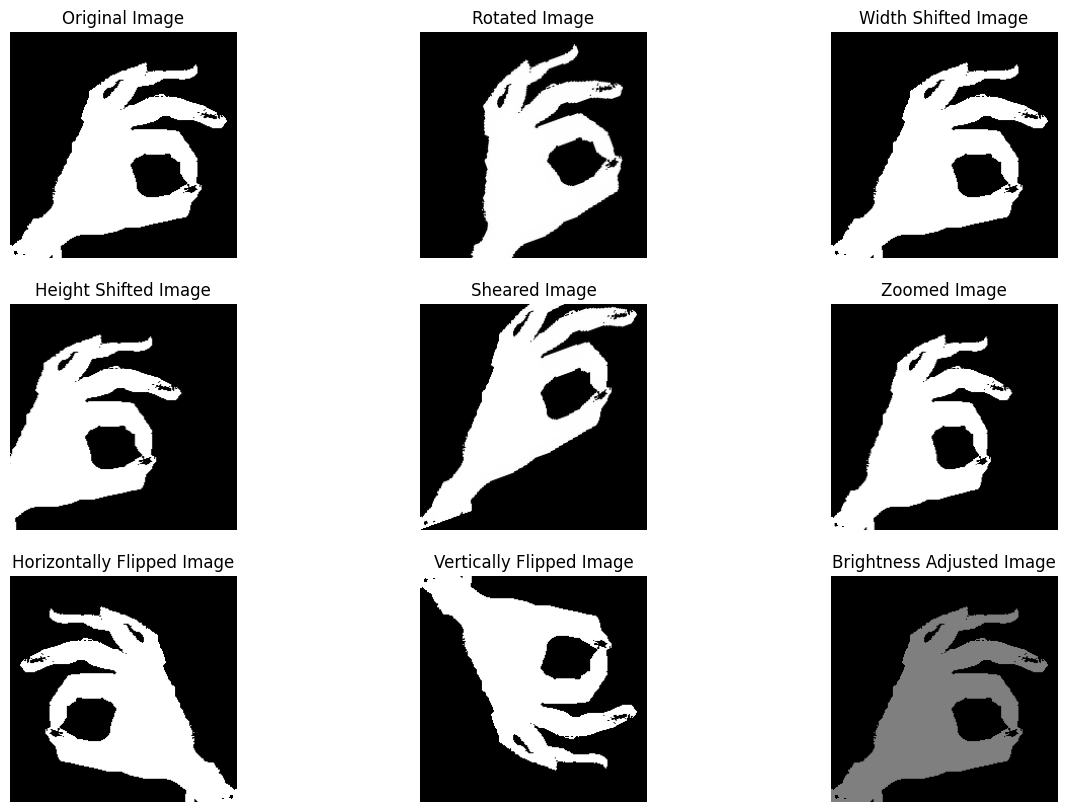

In [23]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img, array_to_img
import numpy as np
from PIL import ImageEnhance

# Image path
img_path = '/Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/Sign_Lang_Custom_Dataset _Final copy/0/K991.png'

# Load and preprocess the image
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)

# Data augmentation functions
def rotate_image(img_array, angle):
    return rotate(img_array, angle, reshape=False)

def shift_image(img_array, width_shift, height_shift):
    return image.apply_affine_transform(img_array, tx=width_shift, ty=height_shift)

def shear_image(img_array, shear):
    afine_tf = np.array([[1, np.tan(np.radians(shear)), 0],
                         [0, 1, 0],
                         [0, 0, 1]])
    return affine_transform(img_array, afine_tf)

def zoom_image(img_array, zoom):
    return image.apply_affine_transform(img_array, zx=zoom, zy=zoom)

def flip_image(img_array, horizontal=False, vertical=False):
    if horizontal:
        img_array = np.fliplr(img_array)
    if vertical:
        img_array = np.flipud(img_array)
    return img_array

def adjust_brightness(img_array, factor):
    img = array_to_img(img_array * 255.0)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(factor)
    return img_to_array(img) / 255.0

# Generate augmented images
augmented_images = [
    img_array / 255.0,  # Original Image
    rotate_image(img_array, 20) / 255.0,  # Rotated Image
    shift_image(img_array, width_shift=0.2*224, height_shift=0) / 255.0,  # Width Shifted Image
    shift_image(img_array, width_shift=0, height_shift=0.2*224) / 255.0,  # Height Shifted Image
    shear_image(img_array, shear=20) / 255.0,  # Sheared Image
    zoom_image(img_array, zoom=1.2) / 255.0,  # Zoomed Image
    flip_image(img_array, horizontal=True) / 255.0,  # Horizontally Flipped Image
    flip_image(img_array, vertical=True) / 255.0,  # Vertically Flipped Image
    adjust_brightness(img_array, factor=0.5),  # Decreased Brightness Image
    adjust_brightness(img_array, factor=1.5)  # Increased Brightness Image
]

# Titles for each augmented image
titles = [
    "Original Image",
    "Rotated Image",
    "Width Shifted Image",
    "Height Shifted Image",
    "Sheared Image",
    "Zoomed Image",
    "Horizontally Flipped Image",
    "Vertically Flipped Image",
    "Brightness Adjusted Image"
]

# Display the images
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.show()
